In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import swyft
import sys
import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch
sys.path.insert(0, "../submarine")
import simulator as sim
import data

from swyft.networks import OnlineStandardizingLayer
from swyft.networks import ResidualNetWithChannel

In [5]:
simulator = sim.SubmarineSim(channels=2)

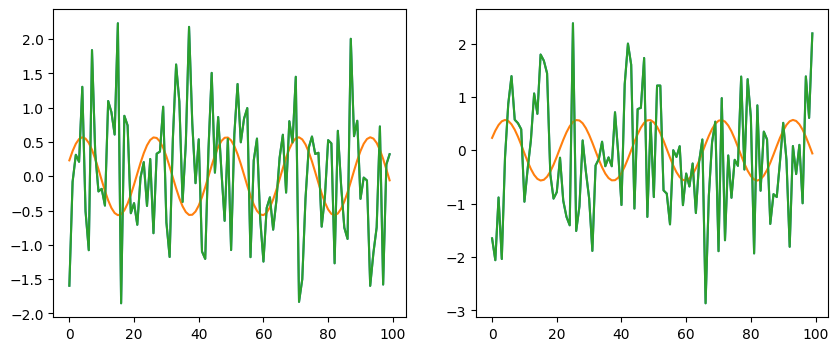

In [6]:
sample = simulator.sample()
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(sample['noise'][0])
ax[0].plot(sample['signal'][0])
ax[0].plot(sample['data'][0])

ax[1].plot(sample['noise'][1])
ax[1].plot(sample['signal'][1])
ax[1].plot(sample['data'][1])

In [ ]:
class Network(swyft.SwyftModule):
    def __init__(self):
        super().__init__()
        self.norm_H = OnlineStandardizingLayer(shape=(100,))
        self.norm_L = OnlineStandardizingLayer(shape=(100,))

        self.resnet = ResidualNetWithChannel(
            channels=2,  # 3,
            in_features=100,
            out_features=1,
        )

        self.xi_logratios = swyft.LogRatioEstimator_Ndim(num_features=2, marginals=1)

    def forward(self, A, B):
        xi_lr = self.xi_logratios(self.norm(A["data"]), B["xi"])
        return xi_lr

In [ ]:


    def forward(self, A, B):
        if torch.isnan(A["data"]).any():
            raise ValueError("NaNs in data")
        if torch.isinf(A["data"]).any():
            raise ValueError("Infs in data")
        if (A["data"] < 0).any():
            raise ValueError("Negative values in data")
        log_data = torch.log(A["data"])

        # NOTE: reshape to (batch, num_channels, num_freqs)
        log_data = log_data.transpose(1, 2)
        norm_AA = self.nl_AA(log_data[..., 0, :])
        norm_EE = self.nl_EE(log_data[..., 1, :])
        norm_TT = self.nl_TT(log_data[..., 2, :])
        arr_list = [norm_AA, norm_EE, norm_TT]
        full_data = torch.stack(
            [arr_list[channel] for channel in self.channel_mask], dim=-2
        )

        no_log_data = torch.exp(torch.stack([norm_AA, norm_EE, norm_TT], dim=-2))
        norm_AA_nolog = self.nl_AA_nolog(no_log_data[..., 0, :])
        norm_EE_nolog = self.nl_EE_nolog(no_log_data[..., 1, :])
        norm_TT_nolog = self.nl_TT_nolog(no_log_data[..., 2, :])
        arr_list_no_log = [norm_AA_nolog, norm_EE_nolog, norm_TT_nolog]
        no_log_data = torch.stack(
            [arr_list_no_log[channel] for channel in self.channel_mask], dim=-2
        )

        compression = self.resnet(full_data)
        no_log_compression = self.resnet_no_log(no_log_data)
        s1 = compression.reshape(-1, self.num_params * self.num_feat_param)
        s2 = no_log_compression.reshape(-1, self.num_params * self.num_feat_param)
        s = torch.cat((s1, s2), dim=1)
        lrs2d = self.lrs2d(s, B["z"][:, :2])  # NOTE: Only need 2d logratio
        return lrs2d  # NOTE: Training 2d logratio only here

    @staticmethod
    def get_marginals(n_params):
        marginals = []
        for i in range(n_params):
            for j in range(n_params):
                if j > i:
                    marginals.append((i, j))
        return tuple(marginals)

In [111]:
dm = data.OnTheFlyDataModule(simulator, Nsims_per_epoch=10000, batch_size=128)
trainer = swyft.SwyftTrainer(accelerator='cpu', max_epochs=30, enable_progress_bar=False)
network = Network()
trainer.fit(network, dm)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/james/Code/mambaforge/envs/default/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint

  | Name         | Type                     | Params
----------------------------------------------------------
0 | norm         | OnlineStandardizingLayer | 0     
1 | xi_logratios | LogRatioEstimator_1dim   | 23.7 K
----------------------------------------------------------
23.7 K    Trainable params
0         Non-trainable params
23.7 K    Total params
0.095     Total estimated model params size (MB)
/Users/james/Code/mambaforge/envs/default/lib/pyt

Reloading best model: /Users/james/Projects/LIGO_SGWB/notebooks/lightning_logs/version_22/checkpoints/epoch=23-step=1320.ckpt


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
The following callbacks returned in `LightningModule.confi

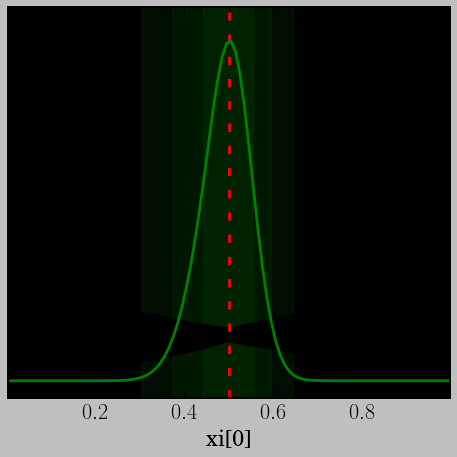

In [112]:
for idx in range(100):
    observation = simulator.sample(conditions={"xi": np.array([0.5])})
    prior_samples = swyft.Samples(
        xi=simulator.transform_samples(np.reshape(np.linspace(0.0, 1.0, 100), (-1, 1)))
    )
    predictions = trainer.infer(
        network, observation, prior_samples.get_dataloader(batch_size=2048)
    )
    if idx == 0:
        lrs_total = predictions
        swyft.plot_posterior(predictions, ["xi[0]"], smooth=2.0);
    else:
        lrs_total.logratios += predictions.logratios
        swyft.plot_posterior(predictions, ["xi[0]"], smooth=2.0, fig=plt.gcf());
plt.axvline(observation["xi"][0], color="red", linestyle="--")
swyft.plot_posterior(lrs_total, ["xi[0]"], smooth=2.0, color='green', fig=plt.gcf());

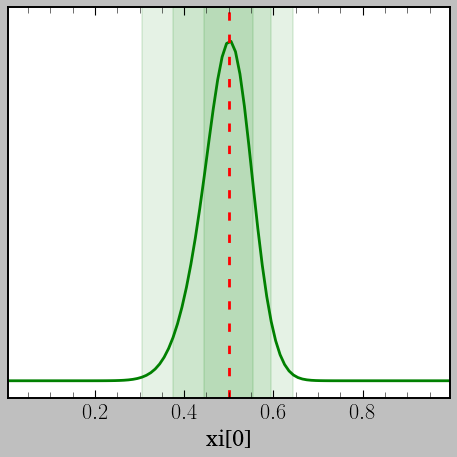

In [113]:
swyft.plot_posterior(lrs_total, ["xi[0]"], smooth=2.0, color='green');
plt.axvline(0.5, color='red', linestyle='--')

In [106]:
class SubmarineStats:
    def __init__(self, simulator):
        self.simulator = simulator
    
    def log_likelihood(self, data, theta):
        mu = data - self.simulator.signal(theta)
        sigma = np.sqrt(self.simulator.psd)
        return -0.5 * np.sum(mu**2 / sigma**2) + np.sum(np.log(sigma))

In [107]:
test_data = simulator.sample(
    targets=["data"],
    conditions={"xi": np.array([1.0]), "theta": np.array([0.6, 0.0, 0.5])},
)

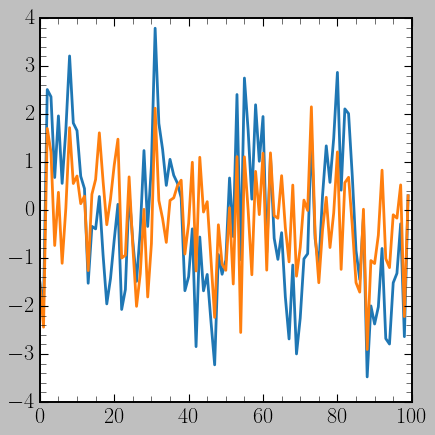

In [108]:
plt.plot(test_data['data'])
plt.plot(test_data['noise'])

100%|██████████| 1000/1000 [00:00<00:00, 18837.77it/s]


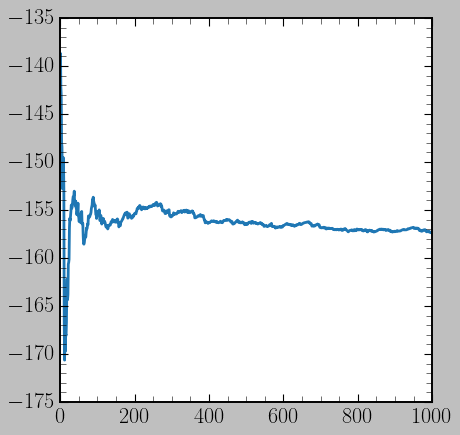

In [109]:
values = []
averages = []
stats_module = SubmarineStats(simulator)
for i in tqdm.tqdm(range(1000)):
    theta = simulator.sample(targets=["theta"])["theta"]
    value = stats_module.log_likelihood(test_data['data'], theta)
    values.append(value)
    averages.append(np.mean(values))
plt.plot(averages)

In [110]:
import dynesty
from dynesty import NestedSampler

# Define the log-likelihood function
def log_likelihood(theta):
    return stats_module.log_likelihood(test_data['data'], theta)

# Define the prior transform function
def prior_transform(utheta):
    # Assuming uniform priors for simplicity
    return utheta * 10  # Scale to the desired range

# Initialize the nested sampler
ndim = 3  # Number of parameters in theta
sampler = NestedSampler(log_likelihood, prior_transform, ndim)

# Run the nested sampler
sampler.run_nested()

# Extract the results
results = sampler.results

# Print the evidence (logZ)
print("Log-evidence: ", results.logz[-1])

1853it [00:00, 2131.85it/s, bound: 1 | nc: 3 | ncall: 18083 | eff(%): 10.247 | loglstar:   -inf < -125.944 <    inf | logz: -129.681 +/-  0.064 | dlogz: 36.681 >  0.509]/Users/james/Code/mambaforge/envs/default/lib/python3.11/site-packages/dynesty/bounding.py:618: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very complex posterior shape. You may consider using more livepoints or different sampler (i.e. rslice or rwalk) or alternatively disable bootstrap (bootstrap=0)
  warnings.warn(
2176it [00:02, 596.49it/s, bound: 10 | nc: 92 | ncall: 24327 | eff(%):  8.945 | loglstar:   -inf < -124.693 <    inf | logz: -129.021 +/-  0.071 | dlogz: 54.893 >  0.509]/Users/james/Code/mambaforge/envs/default/lib/python3.11/site-packages/dynesty/bounding.py:618: UserWarning: The enlargement factor for the ellipsoidal bounds determin

Log-evidence:  -70.12683882096245
